In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
import h5py 
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time


from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer
from qiskit_machine_learning.circuit.library import RawFeatureVector

from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes,EfficientSU2
from sklearn.utils import shuffle
import pandas as pd

In [2]:
def callback_graph(weights, obj_func_eval):
    print(len(objective_func_vals))
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
    
def produceDataset(inputFileName,path,treeName):
    
    print("start preparing",inputFileName)
    file = uproot.open(path+inputFileName+".root")
    tree=file[treeName]
    VariableList=tree.keys()
    

    df = tree.arrays(filter_name=VariableList[0],library="pd") 
    for i in range(1,len(VariableList)):
        df=df.join(tree.arrays(filter_name=VariableList[i],library="pd"))



    return df

def getFourVector(pt,eta,phi):
   
    m=1 # precision issues. not sure why but m=1 makes that no negative invariant mass square.
    px=pt*np.cos(phi)
    py=pt*np.sin(phi)
    pz=pt*np.sinh(eta)
    E=np.sqrt(px**2+py**2+pz**2+m**2)
    return np.array([E,px,py,pz], dtype=np.float64)

def getInvM(v):
    m2=v[0]**2-v[1]**2-v[2]**2-v[3]**2
    
    return np.sqrt(m2)

def getMass(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    v=v1+v2+v3+v4
    m_reco=getInvM(v)
    return m_reco

def getThreeVectors_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    

    output=np.concatenate([v1[1:],v2[1:],v3[1:],v4[1:]])
    return  np.transpose(output)

def getDot_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    
    dot=[]

#     dot.append(getInvM(v1+v1))
#     dot.append(getInvM(v2+v2))
#     dot.append(getInvM(v3+v3))
#     dot.append(getInvM(v4+v4))
    
    dot.append(getInvM(v1+v2))
    dot.append(getInvM(v1+v3))
    dot.append(getInvM(v1+v4))
    dot.append(getInvM(v2+v3))
    dot.append(getInvM(v2+v4))
    dot.append(getInvM(v3+v4))
    dot=np.array(dot)
    

    return np.transpose(dot)
    

In [3]:

nShots=2**12
nMaxIter=300
maxDatasetEvents=5000

Dir="/Users/lizhelun/Desktop/QC/Datasets/"

h4l_VV="ntuple_4mu_VV"
h4l_bkg="ntuple_4mu_bkg"

print("nShots = ",nShots)

nShots =  4096


In [4]:
h4l=produceDataset(h4l_VV,Dir,'HZZ4LeptonsAnalysisReduced')

start preparing ntuple_4mu_VV


In [5]:
bkg=produceDataset(h4l_bkg,Dir,'HZZ4LeptonsAnalysisReduced')

start preparing ntuple_4mu_bkg


In [6]:
m_reco_signal=getMass(h4l)
m_reco_bkg=getMass(bkg)

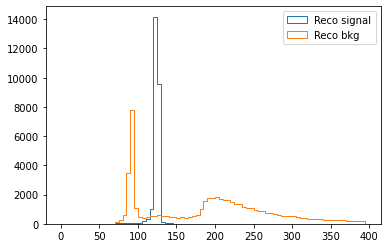

In [7]:
#h4l['f_mass4l'].hist(bins=np.arange(100,150,1),label='truth');
plt.hist(m_reco_signal,bins=np.arange(0,400,5),histtype='step',label='Reco signal');
plt.hist(m_reco_bkg,bins=np.arange(0,400,5),histtype='step',label='Reco bkg');
plt.legend()

In [8]:
sig_3vec=getThreeVectors_df(h4l)
bkg_3vec=getThreeVectors_df(bkg)

In [9]:
sig_dot=getDot_df(h4l)
bkg_dot=getDot_df(bkg)

In [254]:
def split(X,y,normalize=True):
    train_ratio=0.6
    X_train, X_valTest, y_train, y_valTest = train_test_split(X.copy(), y.copy(), train_size=train_ratio, random_state=100)
    X_val, X_test, y_val, y_test = train_test_split(X_valTest, y_valTest, test_size=0.5, random_state=200)
    #Normalizing everythings:
    if normalize:
        X_train=X_train/X_train.max()
        X_val=X_val/X_val.max()
        X_test=X_test/X_test.max()
    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [11]:
X_3=np.concatenate([sig_3vec[0:maxDatasetEvents],bkg_3vec[0:maxDatasetEvents]])
y_3=np.concatenate([np.ones(sig_3vec[0:maxDatasetEvents].shape[0]),-1*np.ones(bkg_3vec[0:maxDatasetEvents].shape[0])])
X_3,y_3=shuffle(X_3,y_3,random_state=1000)

X_train_3,y_train_3,X_val_3,y_val_3,X_test_3,y_test_3=split(X_3,y_3)

In [36]:
X_dot=np.concatenate([sig_dot[0:maxDatasetEvents],bkg_dot[0:maxDatasetEvents]])
y_dot=np.concatenate([np.ones(sig_dot[0:maxDatasetEvents].shape[0]),-1*np.ones(bkg_dot[0:maxDatasetEvents].shape[0])])
X_dot,y_dot=shuffle(X_dot,y_dot,random_state=1000)

X_train_dot,y_train_dot,X_val_dot,y_val_dot,X_test_dot,y_test_dot=split(X_dot,y_dot)

In [260]:
inv_dot=np.concatenate([m_reco_signal[0:maxDatasetEvents],m_reco_bkg[0:maxDatasetEvents]])
inv_dot=shuffle(inv_dot,random_state=1000)
inv_dot_train,inv_doty_train_3,inv_dot_val,inv_doty_val,inv_dot_test,inv_doty_test_3=split(inv_dot,y_3,normalize=False)

In [13]:
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit.circuit import ParameterVector

from qiskit.quantum_info import SparsePauliOp

from qiskit_machine_learning.neural_networks import EstimatorQNN

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR


No symmetry

In [ ]:
nLayer_realAmplitude=2
num_qubits=X_3.shape[1]
n_inputParams=num_qubits
n_params=nLayer_realAmplitude*num_qubits
N_particles=4
print(num_qubits)


In [ ]:
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
ansatz=RealAmplitudes(num_qubits, reps=nLayer_realAmplitude)


qc.compose(feature_map, inplace=True) 
qc.compose(ansatz,inplace=True)    


In [ ]:
observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

estimator_classifier_baseline = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=MaxIter), callback=callback_graph
)



In [ ]:



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier_baseline.fit(X_train_3[0:maxEvents],y_train_3[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)



In [ ]:
# score classifier
print("training score = ",estimator_classifier_baseline.score(X_train_3[0:maxEvents], y_train_3[0:maxEvents]))
print("test score = ",estimator_classifier_baseline.score(X_test_3[0:2*maxEvents], y_test_3[0:2*maxEvents]))


Rotation only

In [ ]:

num_layers=2
N_particles=4
num_qubits=int((N_particles+1)*N_particles/2)
n_params=num_layers*num_qubits
zeroState = '0'
for i in range(num_qubits-1):
    zeroState+='0'
def countZero(x):
    return f"{bin(x)}".count("0")%(num_qubits+1)

In [ ]:
qr_rot = QuantumRegister(num_qubits)
qc_rot = QuantumCircuit(qr_rot)
feature_map_rot = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
ansatz_rot=RealAmplitudes(num_qubits, reps=nLayer_realAmplitude)


inputParams_index=0
params_index=0


qc_rot.compose(feature_map_rot, inplace=True) 
qc_rot.compose(ansatz_rot,inplace=True)    


In [ ]:
observable1_rot = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn_rot = EstimatorQNN(
    circuit=qc_rot, observables=observable1_rot, input_params=feature_map_rot.parameters, weight_params=ansatz_rot.parameters
)
estimator_classifier_rot = NeuralNetworkClassifier(
    estimator_qnn_rot, optimizer=COBYLA(maxiter=MaxIter), callback=callback_graph
)



In [ ]:



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier_rot.fit(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)
# score classifier
print("training score = ",estimator_classifier_rot.score(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents]))
print("test score = ",estimator_classifier_rot.score(X_test_dot[0:2*maxEvents], y_test_dot[0:2*maxEvents]))

Rotation + Permutation

In [14]:

num_layers=2
# n_inputParams=num_qubits
n_params=num_layers*2
N_particles=4
num_qubits=int((N_particles-1)*N_particles/2)

In [15]:

qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")


weights = ParameterVector("weight", n_params)
print(f"weight parameters: {[str(item) for item in weights.params]}")

inputParams_index=0
params_index=0


qc.compose(feature_map, inplace=True) 
   
for layer in range(num_layers):
    
#         for i in range(N_particles):
#             qc.ry(weights[params_index],i)
            
#         params_index += 1 
        
#         for i in range(N_particles):
#             for k in np.arange(i,N_particles,1):
#                 if i!=k:
#                     qc.rzz(weights[params_index],i,k)
            
            
#         params_index += 1
#         for j in np.arange(N_particles,num_qubits,1):
#             qc.ry(weights[params_index],j)
#         params_index += 1
        
#         for i in np.arange(N_particles,num_qubits,1):
#             for k in np.arange(i,num_qubits,1):
#                 if i!=k:
#                     qc.rzz(weights[params_index],i,k)
                    
#         params_index += 1
        
        for j in np.arange(0,num_qubits,1):
            qc.ry(weights[params_index],j)
        
        params_index += 1
        
        for i in np.arange(0,num_qubits,1):
            for k in np.arange(i,num_qubits,1):
                if i!=k:
                    qc.rzz(weights[params_index],i,k)
                    
        params_index += 1
            
        
        qc.barrier()

weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


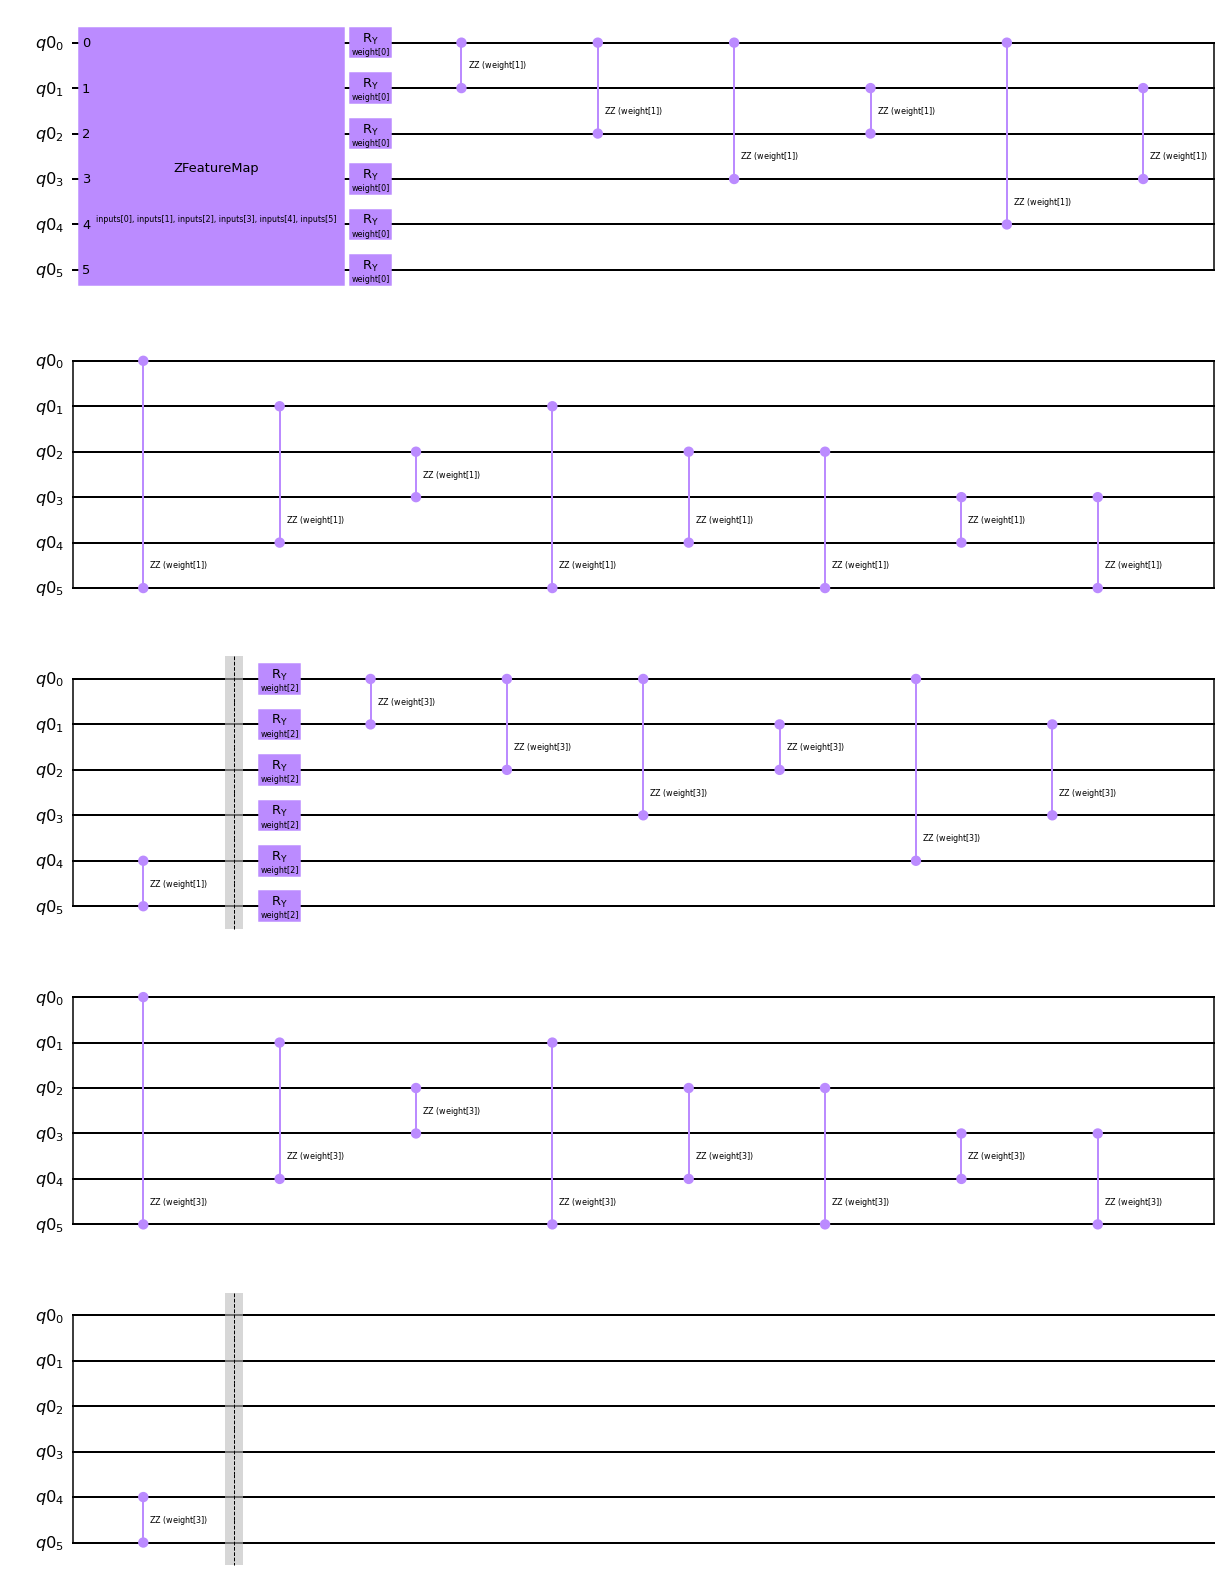

In [16]:
qc.draw('mpl')

In [68]:
MaxIter=50
maxEvents=1000

observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
)

estimator_classifier_rotPerm = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=MaxIter), callback=callback_graph
)

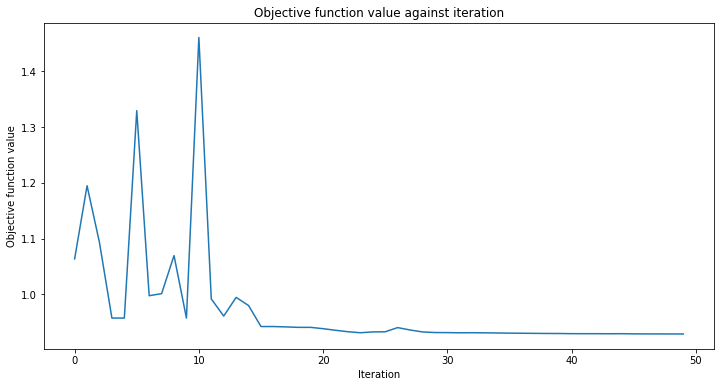

training score =  0.833
test score =  0.707


In [69]:



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


# fit classifier to data
estimator_classifier_rotPerm.fit(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)
# score classifier
print("training score = ",estimator_classifier_rotPerm.score(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents]))
print("test score = ",estimator_classifier_rotPerm.score(X_test_dot[0:2*maxEvents], y_test_dot[0:2*maxEvents]))

In [70]:
#regressor:

In [212]:

num_layers=2
# n_inputParams=num_qubits
n_params=num_layers*2
N_particles=4
num_qubits=int((N_particles-1)*N_particles/2)

In [213]:

qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")


weights = ParameterVector("weight", n_params)
print(f"weight parameters: {[str(item) for item in weights.params]}")

inputParams_index=0
params_index=0

qc.compose(feature_map, inplace=True) 
   
for layer in range(num_layers):

        for j in np.arange(0,num_qubits,1):
            qc.ry(weights[params_index],j)
        
        params_index += 1
        
        for i in np.arange(0,num_qubits,1):
            for k in np.arange(i,num_qubits,1):
                if i!=k:
                    qc.rzz(weights[params_index],i,k)
                    
        params_index += 1
        
        qc.barrier()

weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


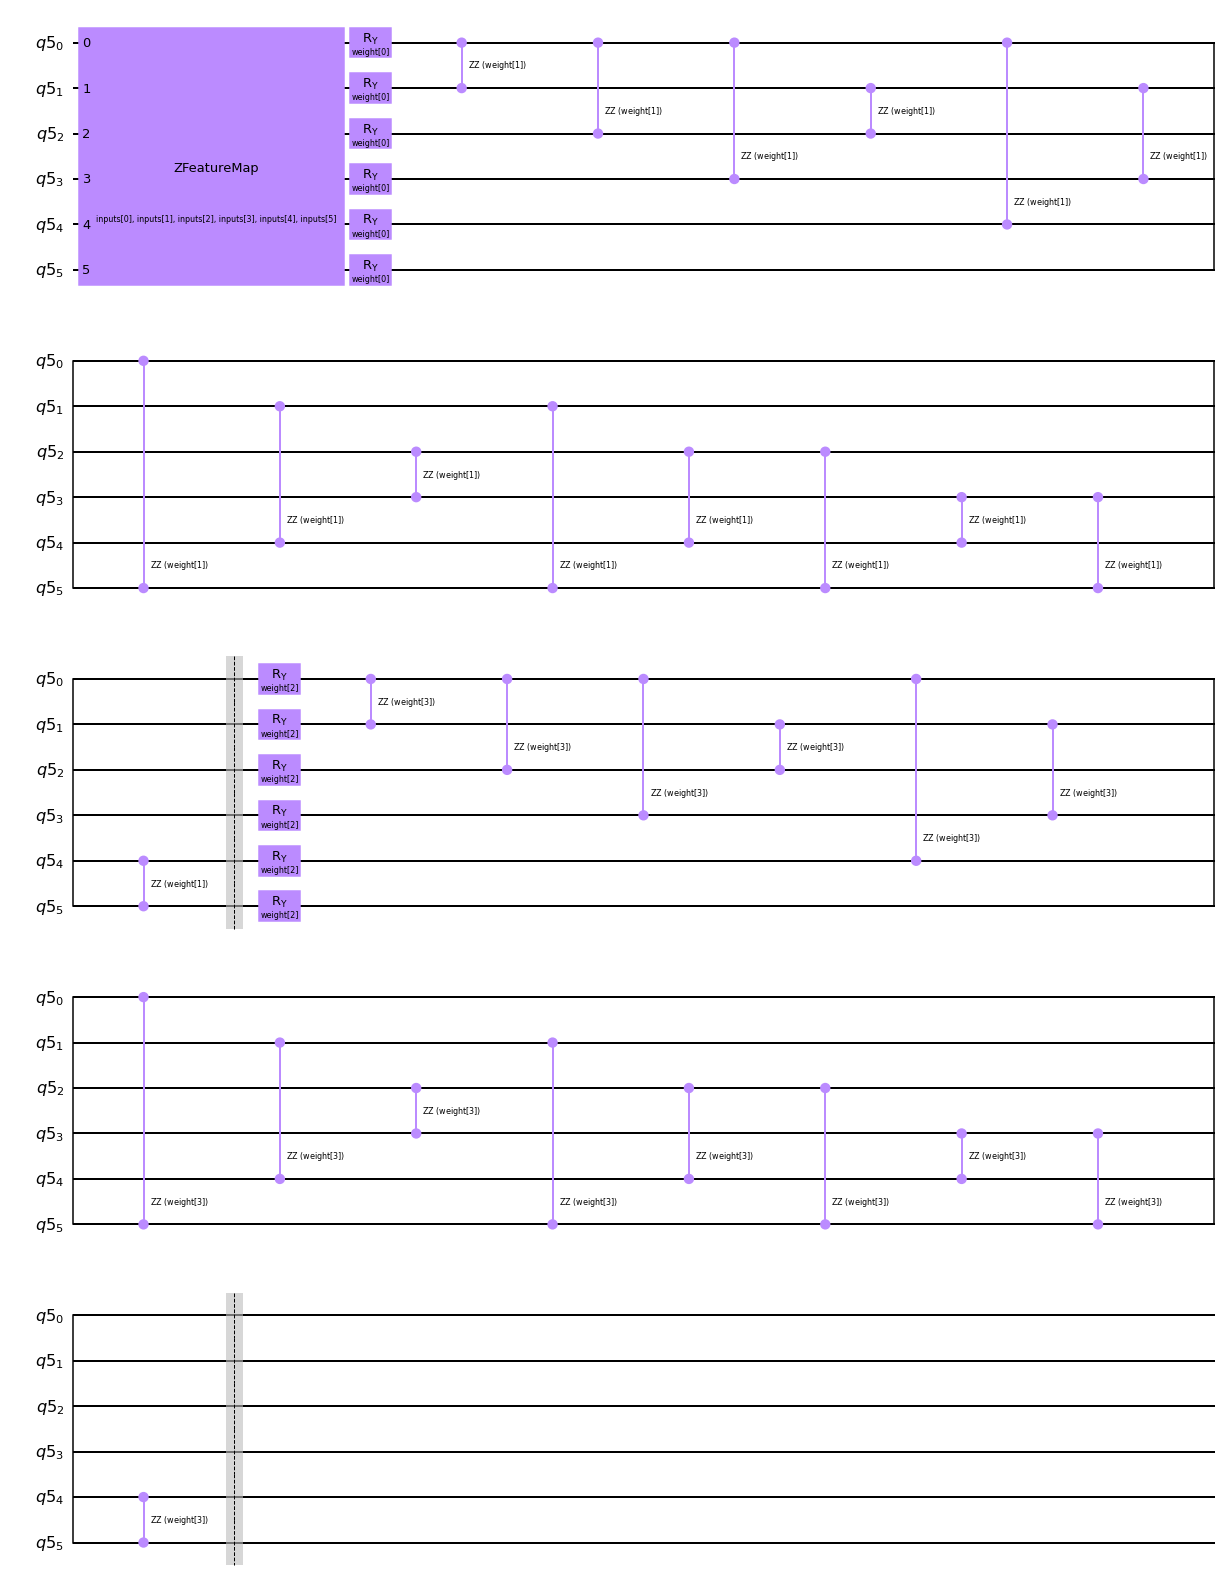

In [214]:
qc.draw('mpl')

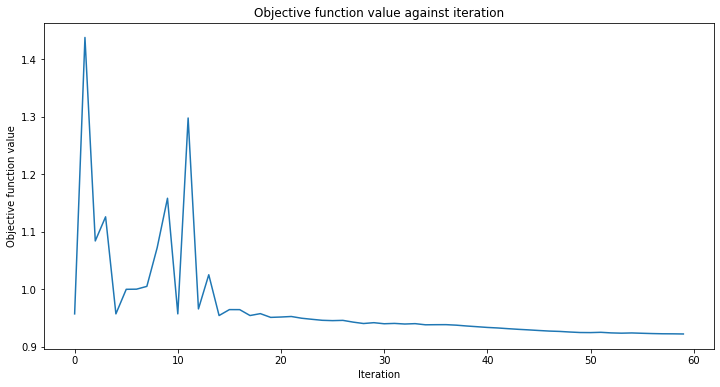

In [215]:
from qiskit_algorithms.optimizers import L_BFGS_B
maxEvents=500
MaxIter=60


observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn_rotPerm = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
)


loss='squared_error'


optimizer=COBYLA(maxiter=MaxIter)

estimator_regressor_rotPerm = NeuralNetworkRegressor(
    estimator_qnn_rotPerm, optimizer=optimizer ,callback=callback_graph,loss=loss
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
plt.grid()

# fit classifier to data
estimator_regressor_rotPerm.fit(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])


In [216]:

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)
# score classifier
print("training score = ",estimator_regressor_rotPerm.score(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents]))
print("test score = ",estimator_regressor_rotPerm.score(X_test_dot[0:maxEvents], y_test_dot[0:maxEvents]))

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay


training score =  0.07778496472710206
test score =  0.06347208076790833


In [259]:
inv_dot_test

array([0.1146266 , 0.06819251, 0.09954391, ..., 0.05673977, 0.21534871,
       0.05661679])

In [261]:
y_predict=estimator_regressor_rotPerm.predict(X_test_dot[0:2*maxEvents])
fpr, tpr, thresholds = metrics.roc_curve(y_test_dot[0:2*maxEvents], y_predict, pos_label=1)

bestValidation=0
inv_dot_all=inv_dot_test[0:2*maxEvents]
for t in thresholds:
    y=y_predict.copy().flatten()
    y[y>t]=1
    y[y<t]=-1
    diff=y-y_test_dot[0:2*maxEvents]
    val=diff[diff==0].shape[0]/y.shape[0]
    if val>bestValidation:
        bestValidation=val
        print(val)
        
        inv_dot_wrong=inv_dot_all[diff!=0]
        inv_dot_correct=inv_dot_all[diff==0]
        
    

0.518
0.602
0.617
0.665
0.695
0.719
0.72
0.809
0.821
0.851


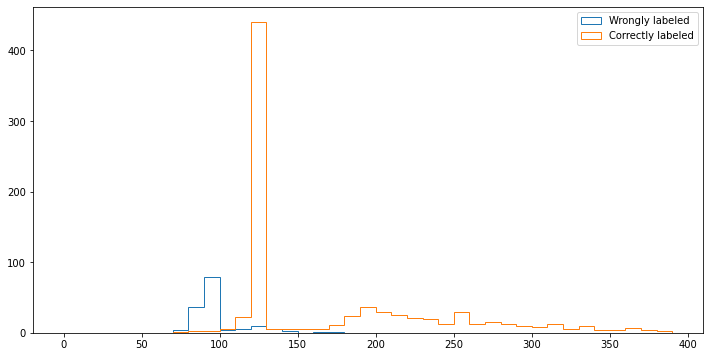

In [263]:
plt.hist(inv_dot_wrong,bins=np.arange(0,400,10),histtype='step',label='Wrongly labeled');
plt.hist(inv_dot_correct,bins=np.arange(0,400,10),histtype='step',label='Correctly labeled');
plt.legend()

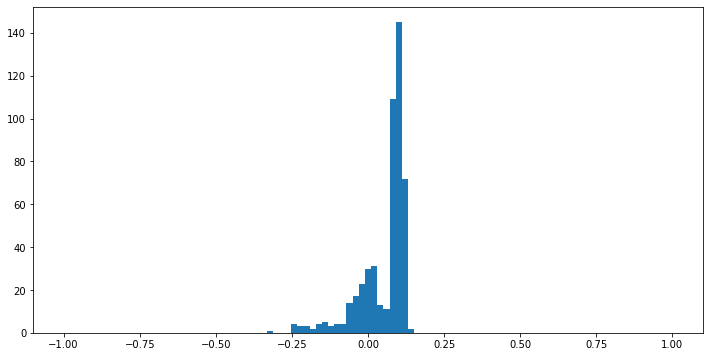

In [218]:
plt.hist(y_predict,bins=np.linspace(-1,1,100));


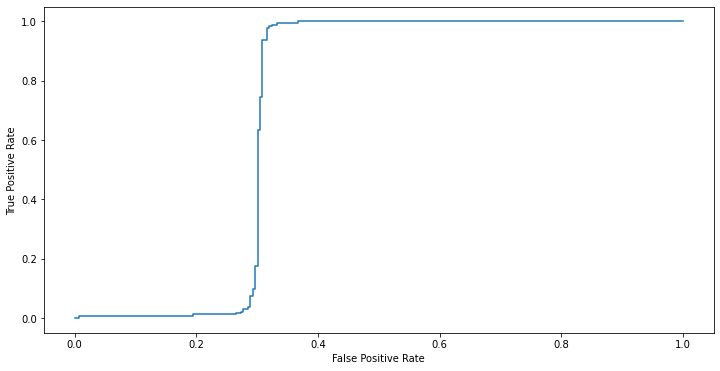

In [219]:
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()

In [37]:
#classical 4vec

In [89]:
from keras import utils 
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import sklearn.neural_network as skl_nn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate 


In [108]:

def getFourVectors_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    

    output=np.concatenate([v1,v2,v3,v4])
    return  np.transpose(output)

sig_4vec=getFourVectors_df(h4l)
bkg_4vec=getFourVectors_df(bkg)

X_4=np.concatenate([sig_4vec[0:maxDatasetEvents],bkg_4vec[0:maxDatasetEvents]])

maxEvents=5000
n_neurons=10

X_onehot=np.concatenate([sig_4vec[0:maxDatasetEvents],bkg_4vec[0:maxDatasetEvents]])
y_onehot=np.concatenate([np.ones(sig_4vec[0:maxDatasetEvents].shape[0]),np.zeros(bkg_4vec[0:maxDatasetEvents].shape[0])])
y_onehot= utils.to_categorical(y_onehot, 2)
X_onehot,y_onehot=shuffle(X_onehot,y_onehot,random_state=1000)


In [109]:
n_neurons_list=[2,3,4,5,10,50]
validation_list=[]
nParams_list=[]

for n_neurons in n_neurons_list:
    print("starting ",n_neurons)
    mlp = skl_nn.MLPClassifier(hidden_layer_sizes=(n_neurons,n_neurons),early_stopping=True, 
                           validation_fraction=0.2,max_iter=10000, verbose=0, random_state=10,
                          n_iter_no_change=1000)
    mlp.fit(X_onehot[0:maxEvents],y_onehot[0:maxEvents])
    best_validation=mlp.best_validation_score_ 
    n_params=X_onehot.shape[1]*n_neurons+(n_neurons**2)*3+n_neurons
    
    validation_list.append(best_validation)
    nParams_list.append(n_params)
    print("best_validation = ",best_validation)

    print("finishing ",n_neurons)

starting  2
finishing  2
starting  5
finishing  5
starting  10
finishing  10
starting  100
finishing  100
starting  150
finishing  150


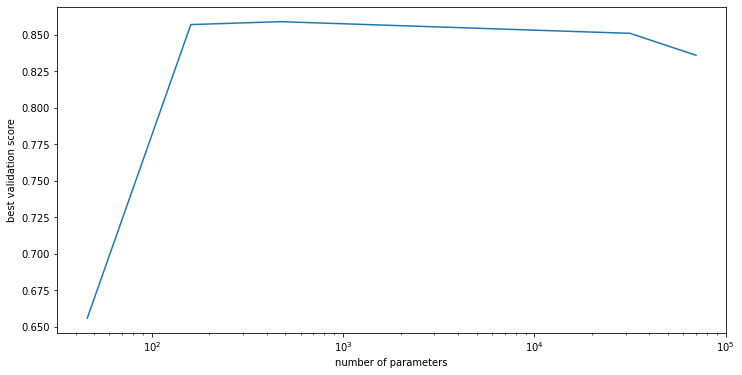

In [114]:
plt.plot(nParams_list,validation_list)
plt.xlabel('number of parameters')
plt.ylabel('best validation score')
plt.xscale('log')

In [168]:
X_onehot.shape[1]

16

In [116]:
#classical lorentz

In [117]:
X_dot_onehot=np.concatenate([sig_dot[0:maxDatasetEvents],bkg_dot[0:maxDatasetEvents]])
y_dot_onehot=np.concatenate([np.ones(sig_4vec[0:maxDatasetEvents].shape[0]),np.zeros(bkg_4vec[0:maxDatasetEvents].shape[0])])

X_dot_onehot,y_dot_onehot=shuffle(X_dot_onehot,y_dot_onehot,random_state=1000)

In [182]:
#single:


n_neurons_list=[1]

validation_list=[]
validation_list_error=[]
nParams_list=[]

for i in range(len(n_neurons_list)):
    
    tmp_validation_list=[]
    for j in range(10):
        mlp = skl_nn.MLPClassifier(hidden_layer_sizes=(n_neurons_list[i]),early_stopping=True, 
                                   validation_fraction=0.2,max_iter=10000, verbose=0,
                                  n_iter_no_change=1000)
        mlp.fit(X_dot_onehot[0:maxEvents],y_dot_onehot[0:maxEvents])
        best_validation=mlp.best_validation_score_ 
        tmp_validation_list.append(best_validation)
        
    tmp_validation_list=np.array(tmp_validation_list)
    n_params=X_onehot.shape[1]*n_neurons_list[i]+n_neurons_list[i]
    
    validation_list.append(tmp_validation_list.mean())
    validation_list_error.append(tmp_validation_list.std())
    nParams_list.append(n_params)
    print("nparams =",n_params,"best_validation = ",tmp_validation_list.mean(),"error = ",tmp_validation_list.std())

    print("finishing ",n_neurons)

nparams = 17 best_validation =  0.68475 error =  0.13610405027037217
finishing  10


In [184]:
#One layer:


n_neurons_list=[2,3,4,5,10]

validation_list=[]
validation_list_error=[]
nParams_list=[]

for i in range(len(n_neurons_list)):
    
    tmp_validation_list=[]
    for j in range(10):
        mlp = skl_nn.MLPClassifier(hidden_layer_sizes=(n_neurons_list[i]),early_stopping=True, 
                                   validation_fraction=0.2,max_iter=10000, verbose=0,
                                  n_iter_no_change=2000)
        mlp.fit(X_dot_onehot[0:maxEvents],y_dot_onehot[0:maxEvents])
        best_validation=mlp.best_validation_score_ 
        tmp_validation_list.append(best_validation)
        
    tmp_validation_list=np.array(tmp_validation_list)
    n_params=X_onehot.shape[1]*n_neurons_list[i]+n_neurons_list[i]
    
    validation_list.append(tmp_validation_list.mean())
    validation_list_error.append(tmp_validation_list.std())
    nParams_list.append(n_params)
    print("nparams =",n_params,"best_validation = ",tmp_validation_list.mean(),"error = ",tmp_validation_list.std())

    print("finishing ",n_neurons)

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


nparams = 34 best_validation =  0.8432499999999999 error =  0.07054298335057854
finishing  10
nparams = 51 best_validation =  0.81975 error =  0.06116013816204146
finishing  10


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


nparams = 68 best_validation =  0.82575 error =  0.06526915427673319
finishing  10


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


nparams = 85 best_validation =  0.9 error =  0.0816394512475433
finishing  10
nparams = 170 best_validation =  0.9460000000000001 error =  0.0467332857821917
finishing  10


In [186]:
#twolayers:


n_neurons_list=[1,2,3,4,5]

validation_list=[]
validation_list_error=[]
nParams_list=[]

for i in range(len(n_neurons_list)):
    
    tmp_validation_list=[]
    for j in range(10):
        mlp = skl_nn.MLPClassifier(hidden_layer_sizes=(2,n_neurons_list[i]),early_stopping=True, 
                                   validation_fraction=0.2,max_iter=10000, verbose=0,
                                  n_iter_no_change=2000)
        mlp.fit(X_dot_onehot[0:maxEvents],y_dot_onehot[0:maxEvents])
        best_validation=mlp.best_validation_score_ 
        tmp_validation_list.append(best_validation)
        
    tmp_validation_list=np.array(tmp_validation_list)
    n_params=n_params=X_onehot.shape[1]*2+2+(n_neurons_list[i]*2)
    
    validation_list.append(tmp_validation_list.mean())
    validation_list_error.append(tmp_validation_list.std())
    nParams_list.append(n_params)
    print("nparams =",n_params,"best_validation = ",tmp_validation_list.mean(),"error = ",tmp_validation_list.std())

    print("finishing ",n_neurons)

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


nparams = 36 best_validation =  0.61375 error =  0.1425274096446013
finishing  10


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.

nparams = 38 best_validation =  0.62425 error =  0.11584499341792895
finishing  10


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.

nparams = 40 best_validation =  0.633 error =  0.10175829204541516
finishing  10


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.

nparams = 42 best_validation =  0.67175 error =  0.11943643707010017
finishing  10


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.

nparams = 44 best_validation =  0.7217499999999999 error =  0.0842470325886912
finishing  10


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
